In [1]:
import sqlite3
import random
import pandas as pd
import numpy as np
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from keras.layers import Dense

from tensorflow.keras.layers import LSTM

import matplotlib.pyplot as plt
import seaborn as sns


2023-06-29 22:43:53.938446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [20]:

con = sqlite3.connect("data/processed_data.db")
cur = con.cursor()
emails = pd.read_sql("Select * from email", con)

In [21]:
data = emails.copy()

In [22]:
import re
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

def extract_structural_features(email_content):
    body_parts = re.findall(r'Content-Type: multipart', email_content)
    num_body_parts = len(body_parts)
    
    alternative_parts = re.findall(r'Content-Type: multipart/alternative', email_content)
    num_alternative_parts = len(alternative_parts)
    
    return num_body_parts, num_alternative_parts

def extract_link_features(email_content):
    links = re.findall(r'<a.*?href="(.*?)".*?>', email_content)
    num_links = len(links)
    
    ip_links = re.findall(r'<a.*?href="http://\d+\.\d+\.\d+\.\d+.*?".*?>', email_content)
    num_ip_links = len(ip_links)
    
    deceptive_links = re.findall(r'<a.*?href="(.*?)".*?>.*?</a>', email_content)
    deceptive_links_count = sum(1 for link in deceptive_links if 'http' not in link)
    
    image_links = re.findall(r'<img.*?src="(.*?)".*?>', email_content)
    num_image_links = len(image_links)
    
    max_dots = max(link.count('.') for link in links) if links else 0
    
    words_indicator = any(re.search(r'\b(click|here|login|update)\b', link, re.IGNORECASE) for link in links)
    
    return num_links, num_ip_links, deceptive_links_count, num_image_links, max_dots, words_indicator

def extract_element_features(email_content):
    is_html = bool(re.search(r'<html', email_content, re.IGNORECASE))
    
    has_javascript = bool(re.search(r'javascript|onclick', email_content, re.IGNORECASE))
    
    has_form_tag = bool(re.search(r'<form', email_content, re.IGNORECASE))
    
    return is_html, has_javascript, has_form_tag

def extract_word_list_features(email_content):
    word_list = ['account', 'update', 'confirm', 'verify', 'secur', 'notif', 'log', 'click', 'inconvenien']
    word_list_indicators = [bool(re.search(r'\b{}\b'.format(word), email_content, re.IGNORECASE)) for word in word_list]
    
    return word_list_indicators

def preprocess_data(dataset):
    processed_data = []
    
    for index, row in dataset.iterrows():
        email_content = row['email_content']
        label = row['label']
        
        # Add a check for NaN or missing email_content
        if pd.isna(email_content):
            continue
        
        structural_features = extract_structural_features(str(email_content))
        link_features = extract_link_features(str(email_content))
        element_features = extract_element_features(str(email_content))
        word_list_features = extract_word_list_features(str(email_content))
        
        processed_email = [*structural_features, *link_features, *element_features, *word_list_features, label]
        processed_data.append(processed_email)
    
    return pd.DataFrame(processed_data, columns=['num_body_parts', 'num_alternative_parts', 'num_links', 'num_ip_links', 'deceptive_links_count', 'num_image_links', 'max_dots', 'words_indicator', 'is_html', 'has_javascript', 'has_form_tag', 'account', 'update', 'confirm', 'verify', 'secur', 'notif', 'log', 'click', 'inconvenien', 'label'])

# Assuming 'data' is your original DataFrame
df = preprocess_data(data)

# Perform feature normalization
scaler = StandardScaler()
normalized_features = scaler.fit_transform(df.drop('label', axis=1))

# Split the normalized features into training and test sets
X_train, X_test, y_train, y_test = train_test_split(normalized_features, df['label'], test_size=0.3, random_state=42)






In [23]:


# Reshape the input data for LSTM
X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# Split a portion of the training data as validation set
X_train_lstm, X_val_lstm, y_train, y_val = train_test_split(X_train_lstm, y_train, test_size=0.2, random_state=42)

# Build a neural network model with LSTM
model = Sequential()
model.add(LSTM(128, input_shape=(1, X_train.shape[1])))
model.add(Dense(1, activation='sigmoid'))

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model with validation
model.fit(X_train_lstm, y_train, epochs=20, batch_size=64, validation_data=(X_val_lstm, y_val), verbose=1)

# Evaluate the model on the test set
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_pred = model.predict(X_test_lstm)

# Convert probabilities to binary predictions
y_pred_binary = np.round(y_pred)




2023-06-30 10:53:57.277534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:53:57.279972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:53:57.281637: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/20


2023-06-30 10:53:57.786287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:53:57.789155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:53:57.790914: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

650/660 [============================>.] - ETA: 0s - loss: 0.3830 - accuracy: 0.8019

2023-06-30 10:54:04.520471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:54:04.522925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:54:04.524733: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

660/660 [==============================] - 8s 5ms/step - loss: 0.3819 - accuracy: 0.8019 - val_loss: 0.3335 - val_accuracy: 0.8264
Epoch 2/20
660/660 [==============================] - 3s 4ms/step - loss: 0.3240 - accuracy: 0.8279 - val_loss: 0.3241 - val_accuracy: 0.8294
Epoch 3/20
660/660 [==============================] - 3s 5ms/step - loss: 0.3175 - accuracy: 0.8301 - val_loss: 0.3199 - val_accuracy: 0.8299
Epoch 4/20
660/660 [==============================] - 3s 4ms/step - loss: 0.3137 - accuracy: 0.8304 - val_loss: 0.3181 - val_accuracy: 0.8295
Epoch 5/20
660/660 [==============================] - 3s 5ms/step - loss: 0.3109 - accuracy: 0.8318 - val_loss: 0.3156 - val_accuracy: 0.8299
Epoch 6/20
660/660 [==============================] - 3s 5ms/step - loss: 0.3092 - accuracy: 0.8328 - val_loss: 0.3159 - val_accuracy: 0.8309
Epoch 7/20
660/660 [==============================] - 3s 5ms/step - loss: 0.3079 - accuracy: 0.8329 - val_loss: 0.3134 - val_accuracy: 0.8312
Epoch 8/20
660/66

2023-06-30 10:55:06.360552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:55:06.365932: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:55:06.369631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

708/708 [==============================] - 2s 2ms/step


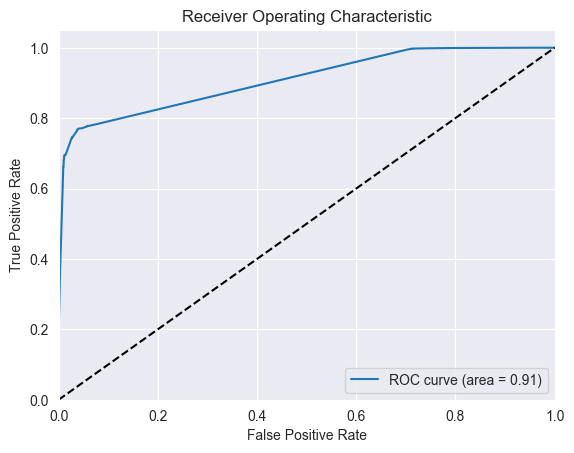

In [24]:
# Create ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()



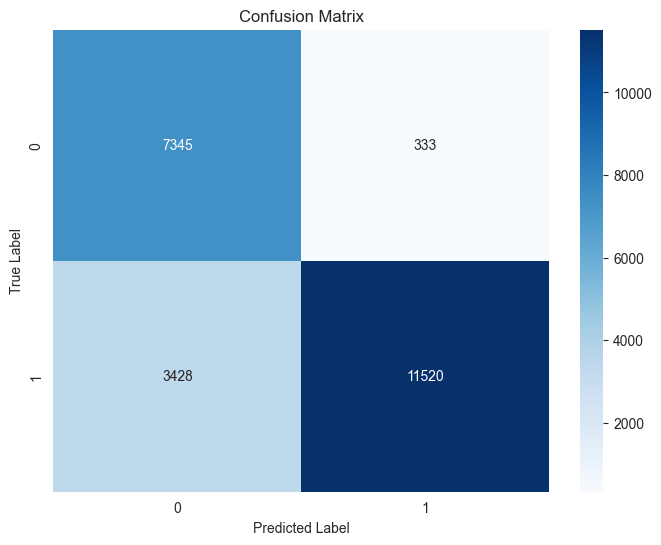

In [25]:

# Create confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [26]:
model.summary()

Model: "sequential_60"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_60 (LSTM)              (None, 128)               76288     
                                                                 
 dense_60 (Dense)            (None, 1)                 129       
                                                                 
Total params: 76,417
Trainable params: 76,417
Non-trainable params: 0
_________________________________________________________________


In [27]:
from sklearn.model_selection import GridSearchCV
import re
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt



# Reshape the input data for LSTM
# X_train_lstm = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
# X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

# # Split a portion of the training data as the validation set
# X_train_lstm, X_val_lstm, y_train, y_val = train_test_split(X_train_lstm, y_train, test_size=0.2, random_state=42)

# Define the parameter grid for grid search
param_grid = {
    'hidden_units': [32, 64, 128],
    'learning_rate': [0.001, 0.01, 0.1]
}

# Build a neural network model
def build_model(hidden_units, learning_rate):
    model = Sequential()
    model.add(LSTM(hidden_units, input_shape=(1, X_train.shape[1])))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Create the model
model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=64, verbose=1)

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3)
grid_search.fit(X_train_lstm, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Train the best model
history = best_model.fit(X_train_lstm, y_train, validation_data=(X_val_lstm, y_val))

# Evaluate the best model
X_test_lstm = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_pred = best_model.predict(X_test_lstm)

# Convert probabilities to binary predictions
y_pred_binary = np.round(y_pred)

# Evaluate the best model on the test set
loss, accuracy = best_model.evaluate(X_test_lstm, y_test)
print("Loss:", loss)
print("Accuracy:", accuracy)

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


/var/folders/vp/bmgsm3216fg61zdd22k8n6jw0000gn/T/ipykernel_12990/847722829.py:35: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(build_fn=build_model, epochs=10, batch_size=64, verbose=1)


Epoch 1/10


2023-06-30 10:55:10.024250: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:55:10.027287: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:55:10.029502: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4469 - accuracy: 0.7688
Epoch 2/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3413 - accuracy: 0.8198
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3287 - accuracy: 0.8237
Epoch 4/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3229 - accuracy: 0.8266
Epoch 5/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3194 - accuracy: 0.8277
Epoch 6/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3167 - accuracy: 0.8281
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3146 - accuracy: 0.8286
Epoch 8/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3130 - accuracy: 0.8290
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3118 - accuracy: 0.8303
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3108 - accuracy: 0.8303


2023-06-30 10:55:32.086560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:55:32.092039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:55:32.095390: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 2s 4ms/step - loss: 0.3049 - accuracy: 0.8377
Epoch 1/10


2023-06-30 10:55:33.949198: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:55:33.952650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:55:33.954552: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4465 - accuracy: 0.7707
Epoch 2/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3410 - accuracy: 0.8238
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3275 - accuracy: 0.8279
Epoch 4/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3214 - accuracy: 0.8310
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3173 - accuracy: 0.8320
Epoch 6/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3145 - accuracy: 0.8324
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3122 - accuracy: 0.8329
Epoch 8/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3109 - accuracy: 0.8325
Epoch 9/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3096 - accuracy: 0.8336
Epoch 10/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3083 - accuracy: 0.8341


2023-06-30 10:55:54.769833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:55:54.773029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:55:54.776265: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3106 - accuracy: 0.8281
Epoch 1/10


2023-06-30 10:55:55.952180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:55:55.954867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:55:55.956697: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4477 - accuracy: 0.7592
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3372 - accuracy: 0.8232
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3231 - accuracy: 0.8278
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3174 - accuracy: 0.8314
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3137 - accuracy: 0.8324
Epoch 6/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3109 - accuracy: 0.8334
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3091 - accuracy: 0.8334
Epoch 8/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3072 - accuracy: 0.8339
Epoch 9/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3062 - accuracy: 0.8344
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3050 - accuracy: 0.8355


2023-06-30 10:56:15.167819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:56:15.172792: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:56:15.175713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 3ms/step - loss: 0.3156 - accuracy: 0.8298
Epoch 1/10


2023-06-30 10:56:16.407071: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:56:16.409423: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:56:16.411060: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 6s 3ms/step - loss: 0.4605 - accuracy: 0.7601
Epoch 2/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3434 - accuracy: 0.8190
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3287 - accuracy: 0.8244
Epoch 4/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3227 - accuracy: 0.8277
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3194 - accuracy: 0.8281
Epoch 6/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3165 - accuracy: 0.8287
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3143 - accuracy: 0.8290
Epoch 8/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3130 - accuracy: 0.8293
Epoch 9/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3117 - accuracy: 0.8301
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3104 - accuracy: 0.8308


2023-06-30 10:56:37.715667: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:56:37.719853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:56:37.724499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 3ms/step - loss: 0.3044 - accuracy: 0.8372
Epoch 1/10


2023-06-30 10:56:39.158354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:56:39.162278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:56:39.165669: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 3ms/step - loss: 0.4553 - accuracy: 0.7602
Epoch 2/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3407 - accuracy: 0.8231
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3277 - accuracy: 0.8281
Epoch 4/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3214 - accuracy: 0.8300
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3176 - accuracy: 0.8317
Epoch 6/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3149 - accuracy: 0.8323
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3127 - accuracy: 0.8329
Epoch 8/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3115 - accuracy: 0.8329
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3098 - accuracy: 0.8331
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3091 - accuracy: 0.8331


2023-06-30 10:57:00.388138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:57:00.392779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:57:00.395827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 3ms/step - loss: 0.3113 - accuracy: 0.8272
Epoch 1/10


2023-06-30 10:57:02.421302: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:57:02.426828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:57:02.429928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 3ms/step - loss: 0.4520 - accuracy: 0.7747
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3400 - accuracy: 0.8212
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3250 - accuracy: 0.8276
Epoch 4/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3190 - accuracy: 0.8304
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3152 - accuracy: 0.8320
Epoch 6/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3125 - accuracy: 0.8329
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3102 - accuracy: 0.8328
Epoch 8/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3083 - accuracy: 0.8340
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3068 - accuracy: 0.8343
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3057 - accuracy: 0.8347


2023-06-30 10:57:20.851030: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:57:20.852501: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:57:20.854434: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3159 - accuracy: 0.8292
Epoch 1/10


2023-06-30 10:57:22.183754: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:57:22.186499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:57:22.188569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4493 - accuracy: 0.7665
Epoch 2/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3410 - accuracy: 0.8208
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3289 - accuracy: 0.8243
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3233 - accuracy: 0.8266
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3202 - accuracy: 0.8278
Epoch 6/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3177 - accuracy: 0.8272
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3155 - accuracy: 0.8286
Epoch 8/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3141 - accuracy: 0.8292
Epoch 9/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3126 - accuracy: 0.8294
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3116 - accuracy: 0.8302


2023-06-30 10:57:42.559626: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:57:42.564535: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:57:42.567551: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3053 - accuracy: 0.8374


2023-06-30 10:57:43.812698: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:57:43.815028: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:57:43.817364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 10:57:44.762991: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:57:44.765585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:57:44.767597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4418 - accuracy: 0.7673
Epoch 2/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3395 - accuracy: 0.8232
Epoch 3/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3267 - accuracy: 0.8277
Epoch 4/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3211 - accuracy: 0.8302
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3177 - accuracy: 0.8314
Epoch 6/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3151 - accuracy: 0.8318
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3131 - accuracy: 0.8320
Epoch 8/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3115 - accuracy: 0.8325
Epoch 9/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3101 - accuracy: 0.8327
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3089 - accuracy: 0.8337


2023-06-30 10:58:06.201796: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:58:06.203245: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:58:06.205288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3106 - accuracy: 0.8276
Epoch 1/10


2023-06-30 10:58:07.442897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:58:07.445544: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:58:07.448068: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 3ms/step - loss: 0.4625 - accuracy: 0.7566
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3401 - accuracy: 0.8211
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3242 - accuracy: 0.8270
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3176 - accuracy: 0.8313
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3135 - accuracy: 0.8324
Epoch 6/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3107 - accuracy: 0.8332
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3085 - accuracy: 0.8335
Epoch 8/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3069 - accuracy: 0.8342
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3059 - accuracy: 0.8346
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3048 - accuracy: 0.8345


2023-06-30 10:58:24.163907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:58:24.166611: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:58:24.168978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3157 - accuracy: 0.8285
Epoch 1/10


2023-06-30 10:58:25.480995: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:58:25.483736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:58:25.485758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 3ms/step - loss: 0.4333 - accuracy: 0.7692
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3370 - accuracy: 0.8211
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3255 - accuracy: 0.8260
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3209 - accuracy: 0.8280
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3183 - accuracy: 0.8277
Epoch 6/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3155 - accuracy: 0.8288
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3137 - accuracy: 0.8291
Epoch 8/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3123 - accuracy: 0.8295
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3112 - accuracy: 0.8290
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3100 - accuracy: 0.8302


2023-06-30 10:58:43.313839: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:58:43.316588: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:58:43.318710: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3054 - accuracy: 0.8376
Epoch 1/10


2023-06-30 10:58:44.302871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:58:44.305450: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:58:44.307600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 3s 3ms/step - loss: 0.4324 - accuracy: 0.7780
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3354 - accuracy: 0.8254
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3233 - accuracy: 0.8293
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3184 - accuracy: 0.8313
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3151 - accuracy: 0.8322
Epoch 6/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3125 - accuracy: 0.8327
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3104 - accuracy: 0.8330
Epoch 8/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3091 - accuracy: 0.8337
Epoch 9/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3082 - accuracy: 0.8345
Epoch 10/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3070 - accuracy: 0.8342


2023-06-30 10:58:59.378928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:58:59.381625: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:58:59.384137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3101 - accuracy: 0.8286
Epoch 1/10


2023-06-30 10:59:00.458255: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:59:00.461157: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:59:00.463089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 4s 3ms/step - loss: 0.4275 - accuracy: 0.7737
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3319 - accuracy: 0.8245
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3211 - accuracy: 0.8291
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3159 - accuracy: 0.8321
Epoch 5/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3124 - accuracy: 0.8324
Epoch 6/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3098 - accuracy: 0.8334
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3079 - accuracy: 0.8342
Epoch 8/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3062 - accuracy: 0.8347
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3050 - accuracy: 0.8346
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3039 - accuracy: 0.8356


2023-06-30 10:59:16.354177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:59:16.356573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:59:16.358430: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3166 - accuracy: 0.8297
Epoch 1/10


2023-06-30 10:59:17.356804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:59:17.359935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:59:17.361742: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 3s 2ms/step - loss: 0.4229 - accuracy: 0.7842
Epoch 2/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3377 - accuracy: 0.8201
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3269 - accuracy: 0.8252
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3220 - accuracy: 0.8277
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3187 - accuracy: 0.8275
Epoch 6/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3161 - accuracy: 0.8277
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3144 - accuracy: 0.8286
Epoch 8/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3127 - accuracy: 0.8291
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3114 - accuracy: 0.8286
Epoch 10/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3100 - accuracy: 0.8297


2023-06-30 10:59:32.258841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:59:32.260304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:59:32.262240: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 1ms/step - loss: 0.3040 - accuracy: 0.8371
Epoch 1/10


2023-06-30 10:59:33.001279: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:59:33.002703: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:59:33.004633: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 3ms/step - loss: 0.4281 - accuracy: 0.7814
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3339 - accuracy: 0.8254
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3234 - accuracy: 0.8292
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3188 - accuracy: 0.8315
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3156 - accuracy: 0.8324
Epoch 6/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3134 - accuracy: 0.8320
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3110 - accuracy: 0.8326
Epoch 8/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3095 - accuracy: 0.8333
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3082 - accuracy: 0.8342
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3074 - accuracy: 0.8342


2023-06-30 10:59:49.650211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:59:49.653156: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:59:49.655067: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3098 - accuracy: 0.8282
Epoch 1/10


2023-06-30 10:59:50.650643: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 10:59:50.653445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 10:59:50.657184: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 3s 2ms/step - loss: 0.4229 - accuracy: 0.7844
Epoch 2/10
440/440 [==============================] - 1s 2ms/step - loss: 0.3321 - accuracy: 0.8246
Epoch 3/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3211 - accuracy: 0.8291
Epoch 4/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3164 - accuracy: 0.8315
Epoch 5/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3131 - accuracy: 0.8324
Epoch 6/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3102 - accuracy: 0.8332
Epoch 7/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3085 - accuracy: 0.8335
Epoch 8/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3073 - accuracy: 0.8340
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3060 - accuracy: 0.8346
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3043 - accuracy: 0.8350


2023-06-30 11:00:06.034284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:00:06.036472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:00:06.037981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 1ms/step - loss: 0.3169 - accuracy: 0.8280
Epoch 1/10


2023-06-30 11:00:06.771907: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:00:06.773608: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:00:06.775298: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4257 - accuracy: 0.7844
Epoch 2/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3359 - accuracy: 0.8213
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3259 - accuracy: 0.8258
Epoch 4/10
440/440 [==============================] - 2s 3ms/step - loss: 0.3216 - accuracy: 0.8280
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3185 - accuracy: 0.8275
Epoch 6/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3164 - accuracy: 0.8282
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3141 - accuracy: 0.8286
Epoch 8/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3126 - accuracy: 0.8293
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3111 - accuracy: 0.8296
Epoch 10/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3103 - accuracy: 0.8299


2023-06-30 11:00:25.544493: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:00:25.545931: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:00:25.547954: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 1ms/step - loss: 0.3035 - accuracy: 0.8381
Epoch 1/10


2023-06-30 11:00:26.294364: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:00:26.296472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:00:26.298828: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4322 - accuracy: 0.7795
Epoch 2/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3338 - accuracy: 0.8255
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3231 - accuracy: 0.8299
Epoch 4/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3184 - accuracy: 0.8314
Epoch 5/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3155 - accuracy: 0.8325
Epoch 6/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3131 - accuracy: 0.8323
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3111 - accuracy: 0.8329
Epoch 8/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3096 - accuracy: 0.8331
Epoch 9/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3085 - accuracy: 0.8337
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3075 - accuracy: 0.8339


2023-06-30 11:00:46.522025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:00:46.523534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:00:46.525425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 3ms/step - loss: 0.3103 - accuracy: 0.8304
Epoch 1/10


2023-06-30 11:00:47.639346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:00:47.641449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:00:47.643135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 5s 4ms/step - loss: 0.4202 - accuracy: 0.7927
Epoch 2/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3302 - accuracy: 0.8236
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3196 - accuracy: 0.8297
Epoch 4/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3148 - accuracy: 0.8324
Epoch 5/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3116 - accuracy: 0.8328
Epoch 6/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3091 - accuracy: 0.8335
Epoch 7/10
440/440 [==============================] - 2s 6ms/step - loss: 0.3073 - accuracy: 0.8337
Epoch 8/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3061 - accuracy: 0.8347
Epoch 9/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3048 - accuracy: 0.8345
Epoch 10/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3037 - accuracy: 0.8357


2023-06-30 11:01:14.837804: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:01:14.845636: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:01:14.850260: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 3s 4ms/step - loss: 0.3146 - accuracy: 0.8290
Epoch 1/10


2023-06-30 11:01:17.261879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:01:17.265772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:01:17.269062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 10s 8ms/step - loss: 0.4091 - accuracy: 0.7832
Epoch 2/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3342 - accuracy: 0.8227
Epoch 3/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3251 - accuracy: 0.8258
Epoch 4/10
440/440 [==============================] - 4s 8ms/step - loss: 0.3209 - accuracy: 0.8272
Epoch 5/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3180 - accuracy: 0.8282
Epoch 6/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3156 - accuracy: 0.8282
Epoch 7/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3137 - accuracy: 0.8294
Epoch 8/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3124 - accuracy: 0.8297
Epoch 9/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3110 - accuracy: 0.8294
Epoch 10/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3102 - accuracy: 0.8300


2023-06-30 11:01:49.915917: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:01:49.918153: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:01:49.919848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3030 - accuracy: 0.8397
Epoch 1/10


2023-06-30 11:01:50.781107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:01:50.783047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:01:50.784851: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 6s 5ms/step - loss: 0.4058 - accuracy: 0.7995
Epoch 2/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3311 - accuracy: 0.8270
Epoch 3/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3220 - accuracy: 0.8303
Epoch 4/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3175 - accuracy: 0.8317
Epoch 5/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3151 - accuracy: 0.8322
Epoch 6/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3123 - accuracy: 0.8330
Epoch 7/10
440/440 [==============================] - 4s 8ms/step - loss: 0.3107 - accuracy: 0.8330
Epoch 8/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3092 - accuracy: 0.8329
Epoch 9/10
440/440 [==============================] - 2s 6ms/step - loss: 0.3080 - accuracy: 0.8341
Epoch 10/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3071 - accuracy: 0.8342


2023-06-30 11:02:19.615047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:02:19.617395: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:02:19.622564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3108 - accuracy: 0.8288
Epoch 1/10


2023-06-30 11:02:20.739969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:02:20.743274: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:02:20.745283: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 8s 7ms/step - loss: 0.4101 - accuracy: 0.7844
Epoch 2/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3283 - accuracy: 0.8261
Epoch 3/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3192 - accuracy: 0.8305
Epoch 4/10
440/440 [==============================] - 3s 8ms/step - loss: 0.3146 - accuracy: 0.8325
Epoch 5/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3118 - accuracy: 0.8328
Epoch 6/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3093 - accuracy: 0.8334
Epoch 7/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3076 - accuracy: 0.8340
Epoch 8/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3060 - accuracy: 0.8347
Epoch 9/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3048 - accuracy: 0.8351
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3040 - accuracy: 0.8347


2023-06-30 11:02:51.514893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:02:51.518811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:02:51.523722: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 2s 4ms/step - loss: 0.3158 - accuracy: 0.8292


2023-06-30 11:02:53.647002: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:02:53.655295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:02:53.665738: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 11:02:54.630707: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:02:54.636293: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:02:54.640822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 8s 6ms/step - loss: 0.4093 - accuracy: 0.7950
Epoch 2/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3332 - accuracy: 0.8227
Epoch 3/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3243 - accuracy: 0.8258
Epoch 4/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3204 - accuracy: 0.8267
Epoch 5/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3173 - accuracy: 0.8279
Epoch 6/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3148 - accuracy: 0.8285
Epoch 7/10
440/440 [==============================] - 2s 6ms/step - loss: 0.3134 - accuracy: 0.8291
Epoch 8/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3115 - accuracy: 0.8299
Epoch 9/10
440/440 [==============================] - 1s 3ms/step - loss: 0.3108 - accuracy: 0.8296
Epoch 10/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3098 - accuracy: 0.8304


2023-06-30 11:03:23.368329: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:03:23.374678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:03:23.378853: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 2s 4ms/step - loss: 0.3032 - accuracy: 0.8375


2023-06-30 11:03:25.401238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:03:25.405896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:03:25.408847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 11:03:26.453320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:03:26.461882: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:03:26.467411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 9s 6ms/step - loss: 0.4051 - accuracy: 0.7986
Epoch 2/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3322 - accuracy: 0.8259
Epoch 3/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3223 - accuracy: 0.8300
Epoch 4/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3179 - accuracy: 0.8321
Epoch 5/10
440/440 [==============================] - 2s 6ms/step - loss: 0.3155 - accuracy: 0.8328
Epoch 6/10
440/440 [==============================] - 2s 6ms/step - loss: 0.3127 - accuracy: 0.8324
Epoch 7/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3106 - accuracy: 0.8329
Epoch 8/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3093 - accuracy: 0.8333
Epoch 9/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3080 - accuracy: 0.8342
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3072 - accuracy: 0.8341


2023-06-30 11:03:56.582309: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:03:56.589605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:03:56.592652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 2s 3ms/step - loss: 0.3109 - accuracy: 0.8307


2023-06-30 11:03:57.910518: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:03:57.913545: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:03:57.916174: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 11:03:58.986704: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:03:58.992411: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:03:58.994753: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 8s 6ms/step - loss: 0.4074 - accuracy: 0.8003
Epoch 2/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3292 - accuracy: 0.8259
Epoch 3/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3194 - accuracy: 0.8298
Epoch 4/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3150 - accuracy: 0.8313
Epoch 5/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3123 - accuracy: 0.8330
Epoch 6/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3095 - accuracy: 0.8337
Epoch 7/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3082 - accuracy: 0.8334
Epoch 8/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3062 - accuracy: 0.8344
Epoch 9/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3052 - accuracy: 0.8351
Epoch 10/10
440/440 [==============================] - 2s 4ms/step - loss: 0.3041 - accuracy: 0.8347


2023-06-30 11:04:29.901272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:04:29.905474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:04:29.908774: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 1s 2ms/step - loss: 0.3159 - accuracy: 0.8289


2023-06-30 11:04:31.089577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:04:31.091046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:04:31.093012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 11:04:32.992680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:04:33.000318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:04:33.003506: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 6s 6ms/step - loss: 0.4074 - accuracy: 0.7941
Epoch 2/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3341 - accuracy: 0.8224
Epoch 3/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3246 - accuracy: 0.8256
Epoch 4/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3208 - accuracy: 0.8272
Epoch 5/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3177 - accuracy: 0.8277
Epoch 6/10
440/440 [==============================] - 3s 8ms/step - loss: 0.3157 - accuracy: 0.8283
Epoch 7/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3137 - accuracy: 0.8283
Epoch 8/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3124 - accuracy: 0.8294
Epoch 9/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3107 - accuracy: 0.8301
Epoch 10/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3098 - accuracy: 0.8307


2023-06-30 11:05:04.965618: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:05:04.968462: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:05:04.970879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 2s 3ms/step - loss: 0.3043 - accuracy: 0.8366
Epoch 1/10


2023-06-30 11:05:06.562692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:05:06.566310: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:05:06.568124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 7s 6ms/step - loss: 0.4060 - accuracy: 0.7927
Epoch 2/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3307 - accuracy: 0.8268
Epoch 3/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3221 - accuracy: 0.8295
Epoch 4/10
440/440 [==============================] - 2s 6ms/step - loss: 0.3176 - accuracy: 0.8318
Epoch 5/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3149 - accuracy: 0.8320
Epoch 6/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3123 - accuracy: 0.8325
Epoch 7/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3106 - accuracy: 0.8333
Epoch 8/10
440/440 [==============================] - 3s 6ms/step - loss: 0.3091 - accuracy: 0.8330
Epoch 9/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3081 - accuracy: 0.8341
Epoch 10/10
440/440 [==============================] - 2s 5ms/step - loss: 0.3070 - accuracy: 0.8347


2023-06-30 11:05:36.150384: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:05:36.153973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:05:36.156696: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 2s 4ms/step - loss: 0.3098 - accuracy: 0.8299


2023-06-30 11:05:37.920634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:05:37.924601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:05:37.930799: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 11:05:38.614406: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:05:38.620599: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:05:38.626008: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

440/440 [==============================] - 8s 7ms/step - loss: 0.4019 - accuracy: 0.8020
Epoch 2/10
440/440 [==============================] - 4s 9ms/step - loss: 0.3286 - accuracy: 0.8254
Epoch 3/10
440/440 [==============================] - 4s 10ms/step - loss: 0.3194 - accuracy: 0.8306
Epoch 4/10
440/440 [==============================] - 4s 9ms/step - loss: 0.3154 - accuracy: 0.8321
Epoch 5/10
440/440 [==============================] - 4s 10ms/step - loss: 0.3119 - accuracy: 0.8329
Epoch 6/10
440/440 [==============================] - 4s 10ms/step - loss: 0.3098 - accuracy: 0.8334
Epoch 7/10
440/440 [==============================] - 3s 7ms/step - loss: 0.3083 - accuracy: 0.8341
Epoch 8/10
440/440 [==============================] - 4s 8ms/step - loss: 0.3067 - accuracy: 0.8345
Epoch 9/10
440/440 [==============================] - 3s 8ms/step - loss: 0.3053 - accuracy: 0.8343
Epoch 10/10
440/440 [==============================] - 3s 8ms/step - loss: 0.3043 - accuracy: 0.8348


2023-06-30 11:06:21.990151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:06:21.998528: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:06:22.004484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

220/220 [==============================] - 3s 7ms/step - loss: 0.3162 - accuracy: 0.8297


2023-06-30 11:06:26.636975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:06:26.646975: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:06:26.653397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 11:06:29.640369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:06:29.655575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:06:29.660683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

660/660 [==============================] - 18s 6ms/step - loss: 0.3834 - accuracy: 0.7963
Epoch 2/10
660/660 [==============================] - 4s 7ms/step - loss: 0.3237 - accuracy: 0.8277
Epoch 3/10
660/660 [==============================] - 4s 7ms/step - loss: 0.3173 - accuracy: 0.8304
Epoch 4/10
660/660 [==============================] - 4s 7ms/step - loss: 0.3139 - accuracy: 0.8312
Epoch 5/10
660/660 [==============================] - 5s 7ms/step - loss: 0.3110 - accuracy: 0.8319
Epoch 6/10
660/660 [==============================] - 5s 8ms/step - loss: 0.3092 - accuracy: 0.8320
Epoch 7/10
660/660 [==============================] - 5s 8ms/step - loss: 0.3076 - accuracy: 0.8330
Epoch 8/10
660/660 [==============================] - 5s 8ms/step - loss: 0.3065 - accuracy: 0.8335
Epoch 9/10
660/660 [==============================] - 5s 7ms/step - loss: 0.3054 - accuracy: 0.8336
Epoch 10/10
660/660 [==============================] - 5s 7ms/step - loss: 0.3045 - accuracy: 0.8343


2023-06-30 11:07:30.262256: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:07:30.272105: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:07:30.274749: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/10


2023-06-30 11:07:31.404142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:07:31.407967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:07:31.413367: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

659/660 [============================>.] - ETA: 0s - loss: 0.3808 - accuracy: 0.8014

2023-06-30 11:07:46.338585: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:07:46.342822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:07:46.346125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

660/660 [==============================] - 18s 14ms/step - loss: 0.3807 - accuracy: 0.8014 - val_loss: 0.3322 - val_accuracy: 0.8263
Epoch 2/10
660/660 [==============================] - 5s 8ms/step - loss: 0.3241 - accuracy: 0.8281 - val_loss: 0.3251 - val_accuracy: 0.8280
Epoch 3/10
660/660 [==============================] - 7s 11ms/step - loss: 0.3176 - accuracy: 0.8297 - val_loss: 0.3211 - val_accuracy: 0.8290
Epoch 4/10
660/660 [==============================] - 5s 7ms/step - loss: 0.3135 - accuracy: 0.8311 - val_loss: 0.3180 - val_accuracy: 0.8300
Epoch 5/10
660/660 [==============================] - 4s 6ms/step - loss: 0.3112 - accuracy: 0.8313 - val_loss: 0.3163 - val_accuracy: 0.8307
Epoch 6/10
660/660 [==============================] - 5s 7ms/step - loss: 0.3090 - accuracy: 0.8323 - val_loss: 0.3154 - val_accuracy: 0.8304
Epoch 7/10
660/660 [==============================] - 5s 7ms/step - loss: 0.3075 - accuracy: 0.8329 - val_loss: 0.3136 - val_accuracy: 0.8322
Epoch 8/10
660

2023-06-30 11:08:34.038566: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-06-30 11:08:34.044871: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-06-30 11:08:34.048848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

708/708 [==============================] - 3s 3ms/step


AttributeError: 'KerasClassifier' object has no attribute 'evaluate'

,num_body_parts,num_alternative_parts,num_links,num_ip_links,deceptive_links_count,num_image_links,max_dots,words_indicator,is_html,has_javascript,...,account,update,confirm,verify,secur,notif,log,click,inconvenien,label
0,1,1,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,0,0,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,1
2,0,0,0,0,0,0,0,False,False,False,...,False,True,False,False,False,False,False,True,False,0
3,0,0,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,True,False,1
4,0,0,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11906,0,0,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,0
11907,1,1,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,1
11908,0,0,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,1
11909,0,0,0,0,0,0,0,False,False,False,...,False,False,False,False,False,False,False,False,False,1
